<a href="https://colab.research.google.com/github/trucareer/myrepo/blob/main/LLM_Chatbot_with_RAG_(Gemma_2b_it).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generator Component: LLM Model

In [ ]:
!pip install python-dotenv

In [ ]:
import os

from dotenv import load_dotenv
load_dotenv()

ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")

In [ ]:
!pip install torch transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Restart the kernel.

In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from dotenv import load_dotenv
load_dotenv()

ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")  # read .env file with ACCESS_TOKEN = <hugging face token>
model_id = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=ACCESS_TOKEN)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map = "cpu", token=ACCESS_TOKEN)

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

LLM model inference function.

In [ ]:
def generate(question: str, context:str):
  if context == None or context == "":
    prompt = f"""Given a detailed answer to the following question. Question: {question}"""
  else:
    prompt = f"""Using the information contained in the context, give a detailed to the question.
      Context: {context}.
      Question: {question}"""

  chat = [{"role": "user", "content": prompt}]
  formatted_prompt = tokenizer.apply_chat_template(
      chat,
      tokenize = False,
      add_generation_prompt = True,
  )
  inputs = tokenizer.encode(
      formatted_prompt, add_special_tokens = False, return_tensors = "pt").to(device)
  with torch.no_grad():
    outputs = model.generate(
        input_ids = inputs,
        max_new_tokens = 250,
        do_sample = False
    )
  response = tokenizer.decode(outputs[0], skip_special_tokens=False)
  response = response[len(formatted_prompt) :]  # remove input prompt from response
  response = response.replace("<eos>","") # remove eos token
  return response

The generate() function can be used to simply answer a question or to answer a question with additional context(which will retrieve from documents.)

In [ ]:
question = "What is a transformer?"
print(generate(question, context=""))

Sure, here's a detailed answer to the question:

**What is a Transformer?**

A transformer is an electrical device that transfers energy from one circuit to another through an alternating current (AC) current. It consists of two or more coils of wire wound around a core of ferromagnetic material, such as iron or silicon. When an alternating current is passed through the primary coil, it creates a magnetic field. This magnetic field then induces an alternating current in the secondary coil, even if there is no direct connection between the coils.

**Key Features of Transformers:**

* **Mutual Inductance:** Transformers induce an electromotive force (EMF) in the secondary coil when an EMF is induced in the primary coil.
* **Voltage Transformation:** Transformers can step up or step down the voltage of an alternating current.
* **Current Transformation:** Transformers can also step up or step down the current of an alternating current.
* **Isolation:** Transformers provide isolation betwe

In [ ]:
print(generate(question="How are you?", context=""))

I am an AI language model, and do not have personal experiences or feelings. I am designed to assist and provide information based on the knowledge I have been trained on.


## Retriever Component: Encoder Model + Similarity Search

The task of the encoder model is to compress text consiting of multiple sentences into a dense vector representation that encodes all information into a high-dimensional feature space.

Here use **"all-MiniLM-L12-V2"** encoder model, which is only 120 MB and encodes text into a **384-dimensional vector**.

In [ ]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
from langchain_community.embeddings import (
    HuggingFaceEmbeddings
)

encoder = HuggingFaceEmbeddings(
    model_name = 'sentence-transformers/all-MiniLM-L12-V2',
    model_kwargs = {'device': "cpu"}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# test encoder by embed_query()
embeddings = encoder.embed_query("How are you?")

In [ ]:
print(embeddings)

[-0.03747698292136192, -0.02319679595530033, 0.07719672471284866, 0.015475568361580372, -0.044169843196868896, -0.08739355206489563, 0.0647880807518959, 0.06382615864276886, -0.07700024545192719, -0.03895278647542, -0.03143415227532387, -0.061438675969839096, -0.0001054331733030267, -0.043491315096616745, 0.09328925609588623, -0.010666977614164352, 0.04459364712238312, -0.05326062813401222, -0.04465653374791145, 0.025441033765673637, -0.11153898388147354, -0.007827828638255596, 0.005953287240117788, 0.06646040827035904, -0.05543036013841629, 0.0794018805027008, -0.018432507291436195, -0.061437658965587616, -0.020189201459288597, -0.07552528381347656, -0.018343528732657433, -0.047369107604026794, 0.08541182428598404, -0.04132792353630066, 0.00597520312294364, 0.051570042967796326, 0.03858477994799614, -0.008323158137500286, -0.06972430646419525, -0.04586194083094597, 0.06605976819992065, -0.03025473654270172, 0.01913893222808838, 0.023007743060588837, -0.043622855097055435, -0.038614667

In [ ]:
print(len(embeddings))

384


In [ ]:
import numpy as np

q = encoder.embed_query("What is an apple?")
z1 = encoder.embed_query(
    "An apple is a round, edible fruit produced by an apple tree (Malus spp., among them the domestic or orchard apple; Malus domestica). "
)
z2 = encoder.embed_query(
    "The cat, commonly referred to as the domestic cat or house cat, is the only domesticated species in the family Felidae."
)

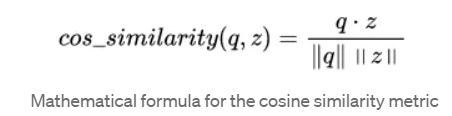

In [ ]:
print(np.dot(q, z1) / (np.linalg.norm(q) * np.linalg.norm(z1)))

0.7321886823078861


In [ ]:
print(np.dot(q, z2) / (np.linalg.norm(q) * np.linalg.norm(z2)))

0.1421435259788551


The cosine similarity ranges from -1 to +1 means, where

* -1 means that the vectors are facing in opposition directions,

* 0 means that the vectors are perpedicular

* +1 means that vectors are facing in the same direction.

## Document Loader and Text Splitter

Build Knowledge base from multiple PDF documents.

In [ ]:
!pip install pypdf tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.2 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# load PDFs
loaders = [
    PyPDFLoader("/content/Make_a_good_graph.pdf"),
    PyPDFLoader("/content/What_Are_ChatGPT_and_Its_Friends.pdf"),
]

pages = []
for loader in loaders:
  pages.extend(loader.load())

# split text to chunks
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer = AutoTokenizer.from_pretrained(
        "sentence-transformers/all-MiniLM-L12-V2"
    ),
    chunk_size = 256,
    chunk_overlap = 32,
    strip_whitespace = True,
)

docs = text_splitter.split_documents(pages)

## Vector Database

Create vector database to store the encoded chunks of text from documents.

**FAISS:**
It's a vector database library from Meta's fundamental AI research team for efficient similarity search and clustering of dense vectors.

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 18.5 MB/s eta 0:00:00


In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

faiss_db = FAISS.from_documents(
    docs, encoder, distance_strategy = DistanceStrategy.COSINE
)

In [ ]:
question = "What is a LLM?"
retrieved_docs = faiss_db.similarity_search(question, k=5)
context = "".join(doc.page_content + "\n" for doc in retrieved_docs)
print(context)

1To distinguish between traditional Bing and the upgraded, AI-driven Bing, we refer to
the latter as Bing/Sydney (or just as Sydney).language models” (LLMs)—though that term isn’t very helpful. The
GPT-series LLMs are also called “foundation models. ” Foundation
models  are a class of very powerful AI models that can be used
as the basis for other models: they can be specialized, or retrained,
or otherwise modified for specific applications. While most of the
foundation models people are talking about are LLMs, foundation
models aren’t limited to language: a generative art model like Stable
Diffusion incorporates the ability to process language, but the ability
to generate images belongs to an entirely different branch of AI.
ChatGPT has gotten the lion’s share of the publicity, but it’s impor‐
tant to realize that there are many similar models, most of which
haven’t been opened to the public—which is why it’s difficult to
several times its size. Facebook’s largest LLaMA model is rough

In [ ]:
torch.cuda.empty_cache()
print(generate(question=question, context=context))

A LLM is a generative art model that can process language. A generative art model is a type of AI model that can generate new content, such as images, videos, or music.


In [ ]:
print("For this answer I used the following documents:")
for doc in retrieved_docs:
  print(doc.metadata)

For this answer I used the following documents:
{'source': '/content/What_Are_ChatGPT_and_Its_Friends.pdf', 'page': 7}
{'source': '/content/What_Are_ChatGPT_and_Its_Friends.pdf', 'page': 11}
{'source': '/content/What_Are_ChatGPT_and_Its_Friends.pdf', 'page': 10}
{'source': '/content/What_Are_ChatGPT_and_Its_Friends.pdf', 'page': 8}
{'source': '/content/What_Are_ChatGPT_and_Its_Friends.pdf', 'page': 24}
